In [1]:
import torch
import numpy as np
from pathlib import Path
import ml_confs as mlc
from kooplearn.data import traj_to_contexts
from kooplearn.nn.data import TrajToContextsDataset

# Data loading

In [2]:
def merge_channels(data_dict, split = 'train', subsample: int = 1) -> np.ndarray:
    channels = [data_dict[key][:,:, None, :] for key in ['U', 'V', 'P', 'C']]
    channels = np.concatenate(channels, axis = 2).transpose((3, 0, 1, 2)) # BHWC
    channels = channels[:, ::subsample, ::subsample, :]
    #Standardize each channel independently
    mean = channels.mean(axis = (0, 1, 2), keepdims = True)
    std = channels.std(axis = (0, 1, 2), keepdims = True)
    channels = (channels - mean)/std
    if split == 'train':
        return channels[:160], (mean, std)
    elif split == 'test':
        return channels[160:], (mean, std)
    else:
        raise ValueError(f"Unknown split {split}")

def load_data(exp_path: Path, configs: mlc.Configs):
    with np.load(exp_path / 'data/cylinder2d_remesh.npz') as f:
        full_data = {k: np.asarray(v) for k, v in f.items()}
    train_ds, (mean, std) = merge_channels(full_data, split='train', subsample = configs.subsample)
    test_ds, _ = merge_channels(full_data, split='test', subsample = configs.subsample)    
    return train_ds, test_ds, np.squeeze(mean), np.squeeze(std)

def channel_from_state(snapshots, mean, std, channel_idx = -1):
    return snapshots[..., channel_idx]*std[channel_idx] + mean[channel_idx]

In [3]:
exp_path = Path.cwd()
# To be replaced with
# exp_path = Path(__file__).parent
configs = mlc.from_file(exp_path / 'configs.yaml', register_jax_pytree=False)

In [4]:
train_ds, test_ds, mean, std = load_data(exp_path, configs)
print(f"{train_ds.shape = }\n{test_ds.shape = }\n{mean.shape = }\n{std.shape = }")

train_ds.shape = (160, 50, 100, 4)
test_ds.shape = (41, 50, 100, 4)
mean.shape = (4,)
std.shape = (4,)


In [5]:
obs_ds = channel_from_state(train_ds, mean, std)
print(f"{obs_ds.shape = }") # [n_samples, H, W]

obs_ds.shape = (160, 50, 100)


## `torch` model definition

In [6]:
class MLP(torch.nn.Module):
    def __init__(
        self, feature_dim, layer_widths: list[int], activation=torch.nn.ReLU
    ):
        super().__init__()
        self.activation = activation
        lin_dims = [feature_dim] + layer_widths
        layers = []
        for i in range(len(layer_widths)):
            layers.append(torch.nn.Linear(lin_dims[i], lin_dims[i+1], bias=True))
            layers.append(activation())
        #Remove last activation
        layers.pop() 
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, x):
        # Flatten input
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x
    
class MLP_r(torch.nn.Module):
    def __init__(
        self, feature_dim, layer_widths: list[int], input_dims: tuple, activation=torch.nn.ReLU
    ):
        super().__init__()
        self.activation = activation
        lin_dims = np.flip([feature_dim] + layer_widths).tolist()
        layers = []
        for i in range(len(layer_widths)):
            layers.append(torch.nn.Linear(lin_dims[i], lin_dims[i+1], bias=True))
            layers.append(activation())
        #Remove last activation
        layers.pop() 
        self.layers = torch.nn.ModuleList(layers)
        self.input_dims = input_dims

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        # Restore dimensions
        x = x.view(x.shape[0], *self.input_dims)
        return x

In [7]:
trail_dims = train_ds.shape[1:]
#Encoder
model = MLP(np.prod(trail_dims), configs.layer_widths)
#Decoder
model_r = MLP_r(np.prod(trail_dims), configs.layer_widths, trail_dims)

In [8]:
# Model summary
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"Trainable parameters: {sum(p.numel() for p in model_r.parameters() if p.requires_grad)}")

Trainable parameters: 3824064
Trainable parameters: 3844000


In [9]:
x = torch.from_numpy(train_ds[:100]).float()
print(x.shape)
y = model(x)
print(y.shape)
z = model_r(y)
print(z.shape)

torch.Size([100, 50, 100, 4])
torch.Size([100, 64])
torch.Size([100, 50, 100, 4])


## Evaluation

In [10]:
from kooplearn.abc import BaseModel

def evaluate(model: BaseModel, exp_path: Path, configs: mlc.Configs):
    train_ds, test_ds, mean, std = load_data(exp_path, configs)

    lookback_len = model.lookback_len
    # Initial condition - last training point
    init = np.expand_dims(train_ds[-1:], 1)
    init = np.concatenate([init for _ in range(lookback_len)], axis = 1)
    def obs_fn(x):
        return channel_from_state(x, mean, std)
    #Predict
    ref = channel_from_state(test_ds, mean, std)
    #MSE
    mse = []
    for t in range(len(test_ds)):
        pred = model.predict(init, t = t, observables=obs_fn)
        mse.append(np.mean((pred - ref[t])**2))
    return np.sqrt(mse)

## Data preparation

In [11]:
#Numpy
np_train = traj_to_contexts(train_ds).astype(np.float32)
#Torch
torch_train = TrajToContextsDataset(train_ds.astype(np.float32))
torch_dl = torch.utils.data.DataLoader(torch_train, batch_size = len(torch_train), shuffle = True)
# Data info
trail_dims = torch_train.contexts.shape[2:]

The provided trajectory is of type <class 'numpy.ndarray'>. Converting to torch.Tensor.


In [51]:
rank = 64
RMSE = {}

In [52]:
from kooplearn.models import KernelDMD #Using the dual as it is faster in this setting 
from sklearn.metrics.pairwise import polynomial_kernel

#DMD
model = KernelDMD(lambda x, y: polynomial_kernel(x, y, degree = 1), rank=rank, reduced_rank=False, tikhonov_reg=1e-5)
model.fit(np_train, verbose=False)

RMSE['DMD'] = evaluate(model, exp_path, configs)

#ExtendedDMD-Poly3
model = KernelDMD(lambda x, y: polynomial_kernel(x, y, degree = 3), rank=rank, reduced_rank=False,  tikhonov_reg=1e-5)
model.fit(np_train, verbose=False)

RMSE['Poly3'] = evaluate(model, exp_path, configs)

## Deep-learning methods

In [53]:
import lightning
from kooplearn.abc import TrainableFeatureMap
from typing import Union
opt = torch.optim.Adam

def tune_learning_rate(
    trainer: lightning.Trainer,
    model: Union[BaseModel, TrainableFeatureMap],
    train_dataloader: torch.utils.data.DataLoader,
):
    # See https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.tuner.tuning.Tuner.html#lightning.pytorch.tuner.tuning.Tuner.lr_find for an explanation of how the lr is chosen
    tuner = lightning.pytorch.tuner.Tuner(trainer)
    # Run learning rate finder
    lr_finder = tuner.lr_find(
        model.lightning_module,
        train_dataloaders=train_dataloader,
        min_lr=1e-6,
        max_lr=1e-3,
        num_training=50,
        early_stop_threshold=None,
        update_attr=True,
    )
    return lr_finder.suggestion()

# Init fn
def kaiming_init(model, trail_dims):
    feature_dim = np.prod(trail_dims)
    for p in model.parameters():
        psh = p.shape
        if len(psh) == 2:  # Linear layers
            _, in_shape = psh
            if in_shape == feature_dim:  # Initial layer
                torch.nn.init.uniform_(p, -1, 1)
            else:
                acname = model.activation.__name__.lower()
                if acname == "leakyrelu":
                    acname = "leaky_relu"
                torch.nn.init.kaiming_uniform_(p, a=1, nonlinearity=acname)
        else:  # Bias
            torch.nn.init.zeros_(p)
def svd_init(model, trail_dims, Vh):
    feature_dim = np.prod(trail_dims)
    for p in model.parameters():
        psh = p.shape
        if len(psh) == 2:  # Linear layers
            out_shape, in_shape = psh
            if in_shape == feature_dim:  # Initial layer
                p.data = torch.from_numpy(Vh[:out_shape])
            else:
                acname = model.activation.__name__.lower()
                if acname == "leakyrelu":
                    acname = "leaky_relu"
                torch.nn.init.kaiming_uniform_(p, a=1, nonlinearity=acname)
        else:  # Bias
            torch.nn.init.zeros_(p)


## DynamicalAE

In [54]:
from kooplearn.models import DynamicAE
from lightning import Trainer

trkw = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs,
    "enable_checkpointing": False,
    "logger": False,
}

trainer = Trainer(**trkw)

model = DynamicAE(
    MLP,
    MLP_r,
    configs.layer_widths[-1],
    opt, {'lr': 1e-3},
    trainer,
    encoder_kwargs={'feature_dim': np.prod(trail_dims), 'layer_widths': configs.layer_widths},
    decoder_kwargs={'feature_dim': np.prod(trail_dims), 'layer_widths': configs.layer_widths, 'input_dims': trail_dims},
    seed = configs.rng_seed
)

#Choose learning rate
lr = tune_learning_rate(trainer, model, torch_dl)
assert model.lightning_module.lr == lr  
model.fit(torch_dl)

#Evaluate Model
RMSE['DynamicalAE'] = evaluate(model, exp_path, configs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/50 [00:00<?, ?it/s]

/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/reconstruction_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/prediction_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/linear_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You c

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


## ConsistentAE

In [55]:
from kooplearn.models import ConsistentAE
from lightning import Trainer

trkw = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs,
    "enable_checkpointing": False,
    "logger": False,
}

trainer = Trainer(**trkw)

model = ConsistentAE(
    MLP,
    MLP_r,
    configs.layer_widths[-1],
    opt, {'lr': 1e-3},
    trainer,
    encoder_kwargs={'feature_dim': np.prod(trail_dims), 'layer_widths': configs.layer_widths},
    decoder_kwargs={'feature_dim': np.prod(trail_dims), 'layer_widths': configs.layer_widths, 'input_dims': trail_dims},
    seed = configs.rng_seed
)

#Data for this
cae_train = TrajToContextsDataset(train_ds.astype(np.float32), context_window_len=3)
cae_dl = torch.utils.data.DataLoader(cae_train, batch_size = len(cae_train), shuffle = True)

# Choose learning rate
lr = tune_learning_rate(trainer, model, cae_dl)
assert model.lightning_module.lr == lr  
model.fit(cae_dl)

# Evaluate Model
RMSE['ConsistentAE'] = evaluate(model, exp_path, configs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


The provided trajectory is of type <class 'numpy.ndarray'>. Converting to torch.Tensor.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/50 [00:00<?, ?it/s]

/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/backward_prediction_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
`Trainer.fit` stopped: `max_steps=50` reached.
Learning rate set to 0.0008709635899560806
Restoring states from the checkpoint path at /home/novelli/dp_examples/fluid/.lr_find_78b85701-4095-4d7e-816a-316ac33fcb6c.ckpt
Restored all states from the checkpoint at /home/novelli/dp_examples/fluid/.lr_find_78b85701-4095-4d7e-816a-316ac33fcb6c.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type   | Params
------------------------------------
0 | encoder  | MLP    | 3.8 M 
1 | decoder  | MLP_r  | 3.8 M 
2 | _lin     | Linear | 4.1 K 
3 | _bwd_lin | Linear | 4.1 K 
------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params


Training: 0it [00:00, ?it/s]

## DPNets

In [ ]:
from kooplearn.models.feature_maps import DPNet

trkw = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs,
    "enable_checkpointing": False,
    "logger": False,
}

trainer = Trainer(**trkw)

fmap = DPNet(
    MLP,
    opt, {'lr': 1e-3},
    trainer,
    use_relaxed_loss=True,
    encoder_kwargs={'feature_dim': np.prod(trail_dims), 'layer_widths': configs.layer_widths},
    encoder_timelagged=MLP,
    encoder_timelagged_kwargs={'feature_dim': np.prod(trail_dims), 'layer_widths': configs.layer_widths},
    seed = configs.rng_seed
)

# Init
_, _, Vh = np.linalg.svd(train_ds.reshape(train_ds.shape[0], -1), full_matrices=False)
Vh = Vh.astype(np.float32)
svd_init(fmap.lightning_module.encoder, trail_dims, Vh)
svd_init(fmap.lightning_module.encoder_timelagged, trail_dims, Vh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


In [ ]:
#Choose learning rate
lr = tune_learning_rate(trainer, fmap, torch_dl)
assert fmap.lightning_module.lr == lr  
fmap.fit(torch_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/50 [00:00<?, ?it/s]

/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/relaxed_projection_score', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/metric_deformation_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/core/module.py:490: UserWarning: You called `self.log('train/total_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
`Trainer.fit` stopped: `max_steps=50` reached.
Learning rate set to 1.8197008586099834e-05
Restoring states from

Fitting DPNet. Lookback window length set to 1


Training: 0it [00:00, ?it/s]

/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
from kooplearn.models import DeepEDMD
model = DeepEDMD(fmap, rank=64, reduced_rank=False, tikhonov_reg=1e-6)
model.fit(np_train, verbose=False)

#Evaluate Model
RMSE['DPNets'] = evaluate(model, exp_path, configs)

In [ ]:
from kooplearn.models import DeepEDMD
model = DeepEDMD(fmap, reduced_rank=False, rank=64,  svd_solver='full')
model.fit(np_train, verbose=False)

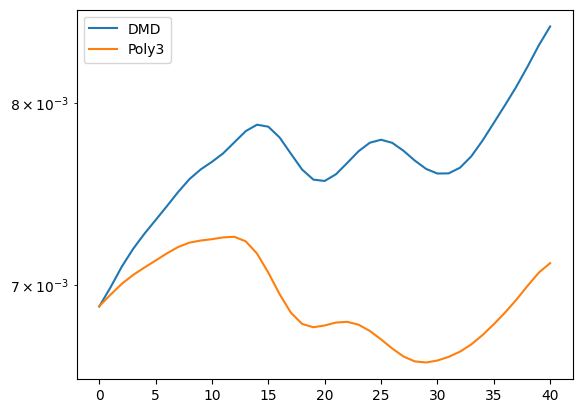

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for model in RMSE:
    ax.plot(RMSE[model], label = model)
ax.set_yscale('log')
ax.legend()